In [37]:
# pip install tensorflow

In [38]:
# Making some essential imports as Usual
import os
import sys
import numpy as np
import re
import cv2
import matplotlib.pyplot as plt
import tensorflow as tf


# Initiate the Model

In [69]:
# defining Conv2d block for our u-net
# this block essentially performs 2 convolution

def Conv2dBlock(inputTensor, numFilters, kernelSize = 3, doBatchNorm = True):
    #first Conv
    x = tf.keras.layers.Conv2D(filters = numFilters, kernel_size = (kernelSize, kernelSize),
                              kernel_initializer = 'he_normal', padding = 'same') (inputTensor)
    
    if doBatchNorm:
        x = tf.keras.layers.BatchNormalization()(x)
        
    x =tf.keras.layers.Activation('relu')(x)
    
    #Second Conv
    x = tf.keras.layers.Conv2D(filters = numFilters, kernel_size = (kernelSize, kernelSize),
                              kernel_initializer = 'he_normal', padding = 'same') (x)
    if doBatchNorm:
        x = tf.keras.layers.BatchNormalization()(x)
        
    x = tf.keras.layers.Activation('relu')(x)
    
    return x



# Now defining Unet 
def GiveMeUnet(inputImage, numFilters = 16, droupouts = 0.1, doBatchNorm = True):
    # defining encoder Path
    c1 = Conv2dBlock(inputImage, numFilters * 1, kernelSize = 3, doBatchNorm = doBatchNorm)
    p1 = tf.keras.layers.MaxPooling2D((2,2))(c1)
    p1 = tf.keras.layers.Dropout(droupouts)(p1)
    
    c2 = Conv2dBlock(p1, numFilters * 2, kernelSize = 3, doBatchNorm = doBatchNorm)
    p2 = tf.keras.layers.MaxPooling2D((2,2))(c2)
    p2 = tf.keras.layers.Dropout(droupouts)(p2)
    
    c3 = Conv2dBlock(p2, numFilters * 4, kernelSize = 3, doBatchNorm = doBatchNorm)
    p3 = tf.keras.layers.MaxPooling2D((2,2))(c3)
    p3 = tf.keras.layers.Dropout(droupouts)(p3)
    
    c4 = Conv2dBlock(p3, numFilters * 8, kernelSize = 3, doBatchNorm = doBatchNorm)
    p4 = tf.keras.layers.MaxPooling2D((2,2))(c4)
    p4 = tf.keras.layers.Dropout(droupouts)(p4)
    
    c5 = Conv2dBlock(p4, numFilters * 16, kernelSize = 3, doBatchNorm = doBatchNorm)
    
    # defining decoder path
    u6 = tf.keras.layers.Conv2DTranspose(numFilters*8, (3, 3), strides = (2, 2), padding = 'same')(c5)
    u6 = tf.keras.layers.concatenate([u6, c4])
    u6 = tf.keras.layers.Dropout(droupouts)(u6)
    c6 = Conv2dBlock(u6, numFilters * 8, kernelSize = 3, doBatchNorm = doBatchNorm)
    
    u7 = tf.keras.layers.Conv2DTranspose(numFilters*4, (3, 3), strides = (2, 2), padding = 'same')(c6)
    u7 = tf.keras.layers.concatenate([u7, c3])
    u7 = tf.keras.layers.Dropout(droupouts)(u7)
    c7 = Conv2dBlock(u7, numFilters * 4, kernelSize = 3, doBatchNorm = doBatchNorm)
    
    u8 = tf.keras.layers.Conv2DTranspose(numFilters*2, (3, 3), strides = (2, 2), padding = 'same')(c7)
    u8 = tf.keras.layers.concatenate([u8, c2])
    u8 = tf.keras.layers.Dropout(droupouts)(u8)
    c8 = Conv2dBlock(u8, numFilters * 2, kernelSize = 3, doBatchNorm = doBatchNorm)
    
    u9 = tf.keras.layers.Conv2DTranspose(numFilters*1, (3, 3), strides = (2, 2), padding = 'same')(c8)
    u9 = tf.keras.layers.concatenate([u9, c1])
    u9 = tf.keras.layers.Dropout(droupouts)(u9)
    c9 = Conv2dBlock(u9, numFilters * 1, kernelSize = 3, doBatchNorm = doBatchNorm)
    
    output = tf.keras.layers.Conv2D(1, (1, 1), activation = 'sigmoid')(c9)
    model = tf.keras.Model(inputs = [inputImage], outputs = [output])
    return model

    
    

In [70]:
## instanctiating model
inputs = tf.keras.layers.Input((256, 256, 3))
unet = GiveMeUnet(inputs, droupouts= 0.07)
unet.compile(optimizer = 'Adam', loss = 'binary_crossentropy', metrics = ['accuracy'] )

# Load Data

In [71]:
# defining function for dataLoading function
framObjTrain = {'img' : [],
           'mask' : []
          }

def LoadData( frameObj = None, imgPath = None, maskPath = None, shape = 256):
    imgNames = os.listdir(imgPath)
#     maskNames = []
    
#     ## generating mask names
#     for mem in imgNames:
#         maskNames.append(re.sub('\.png', '_seg0.png', mem))
    
    imgAddr = imgPath + '/'
    maskAddr = maskPath + '/'
#     print(imgAddr+imgNames[0])
    for i in range (1000):
        img = plt.imread(imgAddr + imgNames[i]) 
        mask = plt.imread(maskAddr + imgNames[i][0:-3]+'png')
#         print(img.shape)
        img = cv2.resize(img, (shape, shape))
        mask = cv2.resize(mask, (shape, shape))
#         print(mask.shape)
#         print(len(framObjTrain['img']))
        frameObj['img'].append(img)
        frameObj['mask'].append(mask[:,:]) # this is because its a binary mask and img is present in channel 0
#     print(framObjTrain['img'])
    return frameObj

In [72]:
framObjTrain = LoadData( framObjTrain, imgPath = 'birds/images', 
                        maskPath = 'birds/segmentations'
                         , shape = 256)
# framObjTrain['img']=framObjTrain['img'][0:1000]
# framObjTrain['mask']=framObjTrain['img'][0:1000]
X_train = np.array(framObjTrain['img'])
Y_train = np.array(framObjTrain['mask'])

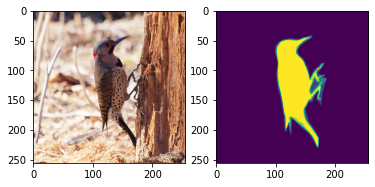

In [73]:
## displaying data loaded by our function
plt.subplot(1,2,1)
plt.imshow(X_train[1])
plt.subplot(1,2,2)
plt.imshow(Y_train[1])
plt.show()

# Train

In [66]:
checkpoint_path = "training_1/cp-{epoch:04d}.ckpt"
checkpoint_dir = os.path.dirname(checkpoint_path)

# Create a callback that saves the model's weights every 5 epochs
cp_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_path, 
    verbose=1, 
    save_weights_only=True,
    save_freq='epoch')

In [10]:
retVal = unet.fit(X_train, Y_train, epochs = 40, callbacks=[cp_callback],verbose = 0)
unet.save('saved_model/my_model')


Epoch 00001: saving model to training_1/cp-0001.ckpt

Epoch 00002: saving model to training_1/cp-0002.ckpt

Epoch 00003: saving model to training_1/cp-0003.ckpt

Epoch 00004: saving model to training_1/cp-0004.ckpt

Epoch 00005: saving model to training_1/cp-0005.ckpt

Epoch 00006: saving model to training_1/cp-0006.ckpt

Epoch 00007: saving model to training_1/cp-0007.ckpt

Epoch 00008: saving model to training_1/cp-0008.ckpt

Epoch 00009: saving model to training_1/cp-0009.ckpt

Epoch 00010: saving model to training_1/cp-0010.ckpt

Epoch 00011: saving model to training_1/cp-0011.ckpt

Epoch 00012: saving model to training_1/cp-0012.ckpt

Epoch 00013: saving model to training_1/cp-0013.ckpt

Epoch 00014: saving model to training_1/cp-0014.ckpt

Epoch 00015: saving model to training_1/cp-0015.ckpt

Epoch 00016: saving model to training_1/cp-0016.ckpt

Epoch 00017: saving model to training_1/cp-0017.ckpt

Epoch 00018: saving model to training_1/cp-0018.ckpt

Epoch 00019: saving model t


# Load the model After trained Directly

In [75]:
# new_model = tf.keras.models.load_model('saved_model/my_model')
# # Check its architecture
# new_model.summary()
# # Evaluate the restored model
# loss, acc = new_model.evaluate(np.array(framObjTrain['img']), np.array(framObjTrain['mask']), verbose=2)
# print('Restored model, accuracy: {:5.2f}%'.format(100 * acc))

# Load the Latest Checkpoint

In [74]:
checkpoint_path = "training_1/cp-{epoch:04d}.ckpt"
checkpoint_dir = os.path.dirname(checkpoint_path)
latest = tf.train.latest_checkpoint(checkpoint_dir)
model = GiveMeUnet(inputs, droupouts= 0.07)
# unet_1.load_weights('./checkpoints/my_checkpoint')
model.load_weights(latest)
model.compile(optimizer = 'Adam', loss = 'binary_crossentropy', metrics = ['accuracy'] )
loss, acc = model.evaluate(np.array(framObjTrain['img']), np.array(framObjTrain['mask']), verbose=2)
print("Restored model, accuracy: {:5.2f}%".format(100 * acc))

32/32 - 43s - loss: 0.0635 - accuracy: 0.9324
Restored model, accuracy: 93.24%


# Loss Plot

In [76]:
# plt.plot(model.historyf['loss'], label = 'training_loss')
# plt.plot(model.history['accuracy'], label = 'training_accuracy')
# plt.legend()
# plt.grid(True)

# Visualize the Result

In [77]:
def predict16 (valMap, model, shape = 256):
    ## getting and proccessing val data
    img = valMap['img']
    mask = valMap['mask']
    mask = mask[0:16]
    
    imgProc = img [0:16]
    imgProc = np.array(imgProc)
    print(imgProc.shape)
    predictions = model.predict(imgProc)
  

    return predictions, imgProc, mask

def Plotter(img, predMask, groundTruth):
    plt.figure(figsize=(9,9))
    
    plt.subplot(1,4,1)
    plt.imshow(img)
    plt.title('image')
    
    plt.subplot(1,4,2)
    plt.imshow(predMask)
    plt.title('Predicted Mask')
    
    plt.subplot(1,4,3)
    plt.imshow(groundTruth)
    plt.title('actual Mask')
    
    imh = predMask
#     imh[imh <= 0.5] = 0
#     imh[imh > 0.5] = 1
    
    plt.subplot(1,4,4)
    plt.imshow((cv2.merge((imh, imh, imh)) * img).astype(int))
    plt.title('segmented Image')

In [78]:
sixteenPrediction, actuals, masks = predict16(framObjTrain, new_model)

(16, 256, 256, 3)


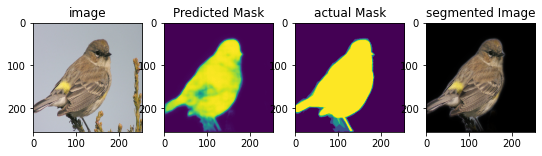

In [79]:
i=10
Plotter(actuals[i], sixteenPrediction[i][:,:,0], masks[i])

In [46]:
def save_segmented_image(img,predMask):
    img=np.squeeze(img)
    predMask=np.squeeze(predMask)
    n=img.shape
    num_image = n[0]
    for i in range(num_image):
        imh = predMask[i]
        imh[imh < 0.5] = 0
        imh[imh > 0.5] = 1
        image = cv2.merge((imh, imh, imh)) * img[i]
        cv2.imwrite('segmented_img/seg_{}.png'.format(i),image*255)
    print('Save Segmented Images Successfully!')

In [ ]:
save_segmented_image(np.array(framObjTrain['img']),sixteenPrediction)